<a href="https://colab.research.google.com/github/RobinHuumonen/Bird-classifier-with-Keras/blob/main/Bird_classifier_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!unzip '/content/drive/MyDrive/Colab Notebooks/100-bird-species.zip' -d '/content/drive/MyDrive/Colab Notebooks/250-bird-species'

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Feb 25 08:03:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    35W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
%matplotlib inline
import matplotlib.pyplot as plotter
import os

print(tf.version.VERSION)
from platform import python_version

print(python_version())

2.4.1
3.7.10


In [4]:
pip install -q pyyaml h5py 

In [5]:
rescaled_ImageDataGenerator = ImageDataGenerator(rescale=1.0/255) #rescale=1./255 scales RGB coefficients from 0–255 to 0–1

In [6]:
pixel_height = pixel_width = 224
batch_size = 64
classes_amount = 250
color_channels = 3
training_samples = 35215
validation_samples = 1250
base_dir = '/content/drive/MyDrive/Colab Notebooks/250-bird-species/'
train = 'train'
valid = 'valid'
test = 'test'

Data downloaded with Kaggle API from [Gerald Piosenka](https://www.kaggle.com/gpiosenka/100-bird-species)

In [7]:
train_generator = rescaled_ImageDataGenerator.flow_from_directory(
    base_dir + train, 
    target_size=(pixel_height,pixel_width), 
    batch_size=batch_size, 
    class_mode='categorical'
)
validation_generator = rescaled_ImageDataGenerator.flow_from_directory(
    base_dir + valid, 
    target_size=(pixel_height,pixel_width), 
    batch_size=batch_size, 
    class_mode='categorical'
)
test_generator = rescaled_ImageDataGenerator.flow_from_directory(
    base_dir + test, 
    target_size=(pixel_height,pixel_width), 
    batch_size=batch_size, 
    class_mode='categorical', 
    shuffle=False
)

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


In [8]:
#Creates MobileNetV2 model with preloaded weights. Src: https://medium.com/hackernoon/tf-serving-keras-mobilenetv2-632b8d92983c
def create_model():
  input_tensor = Input(shape=(pixel_height, pixel_width, 3))
  
  base_model = tf.keras.applications.MobileNetV2(
  include_top=False,
  weights='imagenet',
  input_tensor=input_tensor,
  input_shape=(pixel_height, pixel_width, 3),
  pooling='avg'
)

  for layer in base_model.layers:
    layer.trainable = True  # trainable has to be false in order to freeze the layers

  op = Dense(256, activation='relu')(base_model.output)
  op = Dropout(.25)(op)

  output_tensor = Dense(classes_amount, activation='softmax')(op)

  model = Model(inputs=input_tensor, outputs=output_tensor)

  return model

In [9]:
def load_model_with_previous_weights(weights_path):
  model = create_model()
  model.load_weights(weights_path)
  return model

In [10]:
def evaluate_model(model):
  #train_loss, train_acc = model.evaluate(train_generator, steps=len(train_generator))
  #validation_loss, validation_acc = model.evaluate(validation_generator, steps=len(validation_generator))
  test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
  
  print("Test loss: {0:.4f}".format(test_loss))
  print("Test acc: {0:.4f} % ".format(test_acc * 100.0))

In [11]:
def plot_model(history):
  #Plot the training and validation accuracy and loss at each epoch
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)
  plotter.plot(epochs, loss, 'y', label='Training loss')
  plotter.plot(epochs, val_loss, 'r', label='Validation loss')
  plotter.title('Training and validation loss')
  plotter.xlabel('Epochs')
  plotter.ylabel('Loss')
  plotter.legend()
  plotter.show()


  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  plotter.plot(epochs, acc, 'y', label='Training accuracy')
  plotter.plot(epochs, val_acc, 'r', label='Validation accuracy')
  plotter.title('Training and validation accuracy')
  plotter.xlabel('Epochs')
  plotter.ylabel('Accuracy')
  plotter.legend()
  plotter.show()

In [12]:
model = create_model()
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [13]:
#Save model at some interval during the trainig process
filepath='/content/drive/MyDrive/Colab Notebooks/saved-models/Bird-classifier-v2-weights-improvement/epochs:{epoch:02d}-val_loss:{val_loss:.2f}.hdf5'
#filepath='/content/drive/MyDrive/Colab Notebooks/saved-models/Bird-classifier-v2-weights-improvement/best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#Use early stopping callback to avoid over fitting
stop_early = EarlyStopping(
    monitor='val_loss', 
    min_delta=1e-3, 
    patience=40, 
    verbose=1, 
    mode='auto', 
    restore_best_weights = True
)

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
logs = CSVLogger('/content/drive/MyDrive/Colab Notebooks/Logs/logs-v2.csv', separator=',', append=False)

callbacks = [checkpoint, stop_early, logs]
model_name = '/content/drive/MyDrive/Colab Notebooks/saved-models/Bird-classifier-model-v2.h5'

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = training_samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_samples // batch_size,
    epochs = 280,
    verbose=0,
    callbacks=callbacks
)

model.save(model_name)

In [15]:
evaluate_model(model)

20/20 [==============================] - 4s 182ms/step - loss: 0.1386 - accuracy: 0.9752
Test loss: 0.1386
Test acc: 97.5200 % 


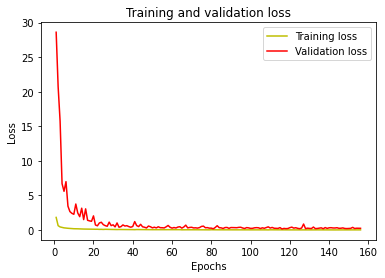

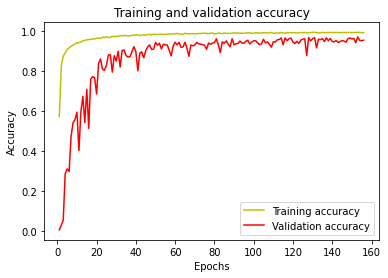

In [16]:
plot_model(history)